Взять с прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [1]:
import pandas as pd

In [2]:
dowj = pd.read_csv('weekly-closings-of-the-dowjones-.csv')
dowj.columns = ['week', 'count']

In [4]:
dowj.head()

,week,count
0,1971-W27,890.19
1,1971-W28,901.80
2,1971-W29,888.51
3,1971-W30,887.78
4,1971-W31,858.43


In [6]:
all_series = {'Weekly closings of the Dow-Jones industrial average, July 1971-August 1974': dowj['count']}

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

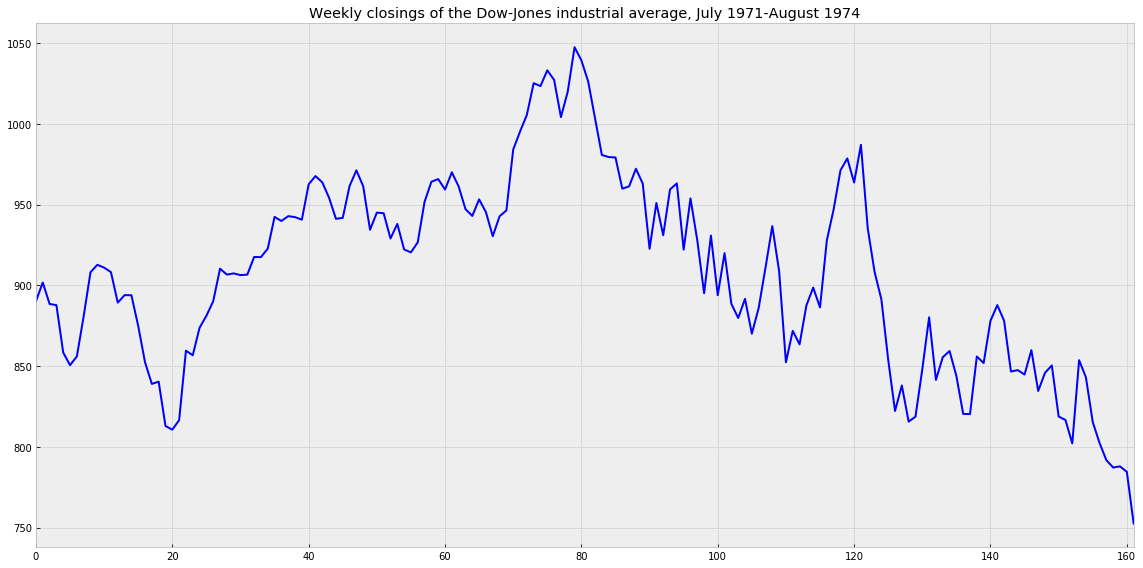

In [15]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (1,1)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

In [16]:
def plot_ts_and_points(ts, start_point, step):
    new_series = [None for i in range(len(ts))]
    for i in range(len(ts)):
        pos = start_point + step * i
        if pos >= len(ts):
            break
        new_series[pos] = ts[pos]
    new_series = pd.Series(new_series)
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        ts_ax = plt.axes()
        ts.plot(ax=ts_ax, color='blue')
        new_series.plot(ax=ts_ax, style='ro')

In [18]:
from scipy.stats import boxcox
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt



################
 # Dickey-Fuller
##################
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [35]:
series = dowj['count']
bc_series = boxcox(dowj['count'], 0)
df_bc_series = np.diff(bc_series, 1)

/home/dmitry/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


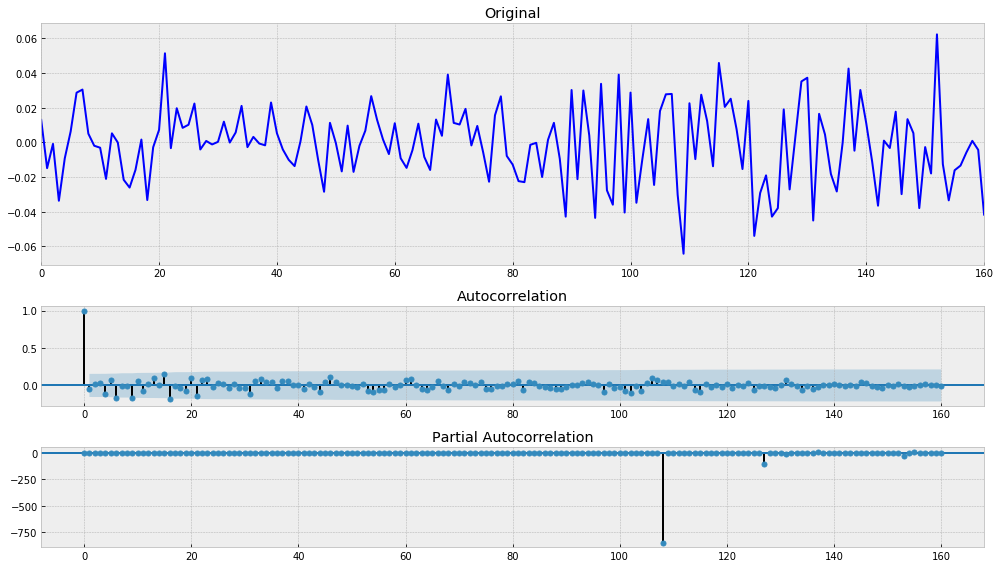

In [27]:
tsplot(df_bc_series)

In [102]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

# MA

In [82]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [90]:
test_stationarity(df_bc_series)

Results of Dickey-Fuller Test:
Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


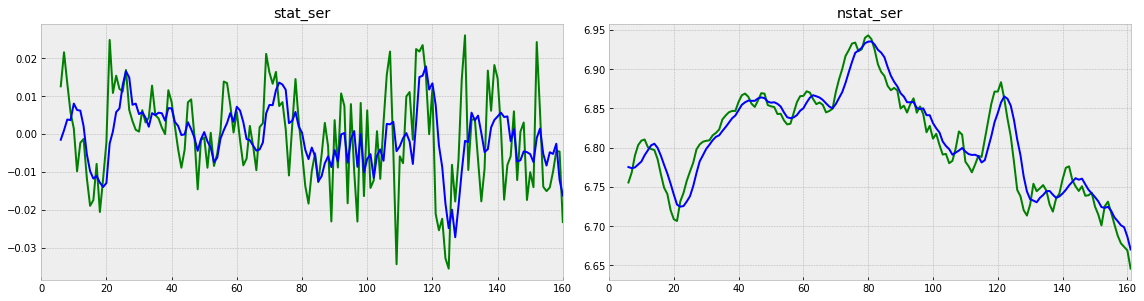

In [83]:
series = dowj['count']
bc_series = boxcox(series, 0)
df_bc_series = np.diff(bc_series, 1)
ser_dict = {'stat_ser':df_bc_ser,
            'nstat_ser':bc_ser}

df_bc_ser = moving_average(df_bc_series, 7)
bc_ser    = moving_average(bc_series, 7)
ser_dict_ma = {'stat_ser':df_bc_ser,
               'nstat_ser':bc_ser}

with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (2,2)
    for i, key in enumerate(ser_dict_ma.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        ser_dict[key].plot(ax=ts_ax, color='green')
        ser_dict_ma[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

In [111]:
train, test, val = series[:100], series[100:140], series[140:]
result = moving_average(train, 7)
predictions = result[-len(test):]
error = mean_squared_error(predictions, test)
error

9373.301568826539

# WMA

In [76]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

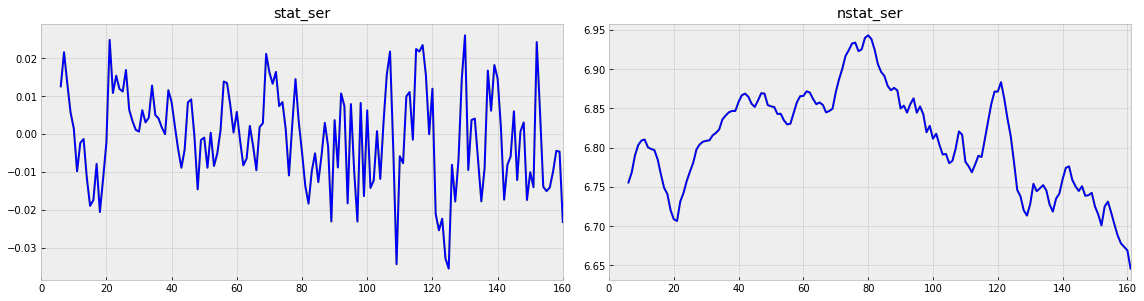

In [89]:
df_bc_ser = weighted_moving_average(df_bc_series, 7, [1,2,4,8,16,32,64])
bc_ser    = weighted_moving_average(bc_series, 7, [1,2,4,8,16,32,64])
ser_dict_wma = {'stat_ser':df_bc_ser,
                'nstat_ser':bc_ser}

with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (2,2)
    for i, key in enumerate(ser_dict_wma.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        
        ser_dict[key].plot(ax=ts_ax, color='yellow')
        #ser_dict_ma[key].plot(ax=ts_ax, color='red')
        ser_dict_wma[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

In [112]:
result = weighted_moving_average(train, 7, [1,2,4,8,16,32,64])
predictions = result[-len(test):]
error = mean_squared_error(predictions, test)
error

9072.011330173136

# EMA

In [118]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

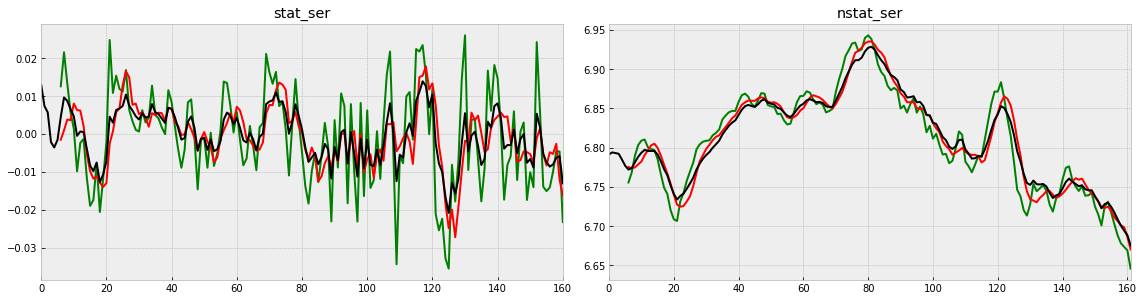

In [119]:
df_bc_ser = exponential_moving_average(df_bc_series, 0.2)
bc_ser    = exponential_moving_average(bc_series, 0.2)
ser_dict_ema = {'stat_ser':df_bc_ser,
                'nstat_ser':bc_ser}

with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (2,2)
    for i, key in enumerate(ser_dict_ema.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        
        ser_dict[key].plot(ax=ts_ax, color='green')
        ser_dict_ma[key].plot(ax=ts_ax, color='red')
        #ser_dict_wma[key].plot(ax=ts_ax, color='blue')
        ser_dict_ema[key].plot(ax=ts_ax, color='black')
        ts_ax.set_title(key)
        
    plt.tight_layout()

In [120]:
result = exponential_moving_average(train, 0.2)
predictions = result[-len(test):]
error = mean_squared_error(predictions, test)
error

9396.574716364328

# DEMA

In [121]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

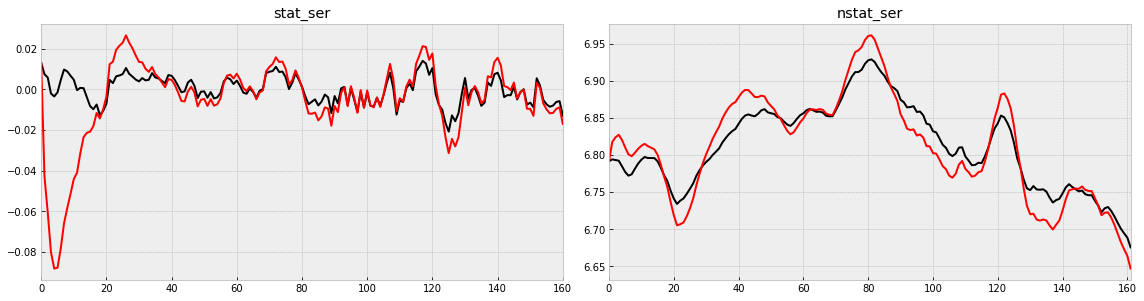

In [122]:
df_bc_ser = double_ema(df_bc_series, 0.2,0.2)
bc_ser    = double_ema(bc_series, 0.2, 0.2)
ser_dict_dema = {'stat_ser':df_bc_ser,
                'nstat_ser':bc_ser}

with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (2,2)
    for i, key in enumerate(ser_dict_dema.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        
        #ser_dict[key].plot(ax=ts_ax, color='green')
        #ser_dict_ma[key].plot(ax=ts_ax, color='red')
        #ser_dict_wma[key].plot(ax=ts_ax, color='blue')
        ser_dict_ema[key].plot(ax=ts_ax, color='black')
        ser_dict_dema[key].plot(ax=ts_ax, color='red')
        ts_ax.set_title(key)
        
    plt.tight_layout()

In [123]:
result = double_ema(train, 0.2,0.2)
predictions = result[-len(test):]
error = mean_squared_error(predictions, test)
error

9453.101966548045